# DiffLUT Experiment Results Visualization

This notebook provides comprehensive visualization of experiment results including:
1. Heatmaps showing max validation accuracy and max train accuracy for different combinations
2. Training curves for top-k performing experiments
3. Gradient and weight evolution heatmaps across different configurations

In [1]:
import sys
import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

# Add experiments directory to path
sys.path.insert(0, '../experiments')
from utils.db_manager import DBManager, Experiment, MeasurementPoint, Metric

# Set plotting style with better aesthetics
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 100

# Paths
DB_PATH = Path('../results/experiments.db')
GRADIENTS_DIR = Path('../results/gradients')
OUTPUT_DIR = Path('../outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Database: {DB_PATH}")
print(f"Database exists: {DB_PATH.exists()}")
print(f"Gradients directory: {GRADIENTS_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Matplotlib is building the font cache; this may take a moment.
Could not save font_manager cache Lock error: Matplotlib failed to acquire the following lock file:
    /home/sbuehrer/.cache/matplotlib/fontlist-v390.json.matplotlib-lock
This maybe due to another process holding this lock file.  If you are sure no
other Matplotlib process is running, remove this file and try again.
Could not save font_manager cache Lock error: Matplotlib failed to acquire the following lock file:
    /home/sbuehrer/.cache/matplotlib/fontlist-v390.json.matplotlib-lock
This maybe due to another process holding this lock file.  If you are sure no
other Matplotlib process is running, remove this file and try again.


Database: ../results/experiments.db
Database exists: True
Gradients directory: ../results/gradients
Output directory: ../outputs


## 1. Load Experiment Data

In [2]:
# Initialize database manager
db_manager = DBManager(str(DB_PATH))
session = db_manager.get_session()

# Query all completed experiments
experiments = session.query(Experiment).filter(
    Experiment.status.in_(['completed', 'running'])
).all()

print(f"Total experiments: {len(experiments)}")
print(f"Completed: {sum(1 for e in experiments if e.status == 'completed')}")
print(f"Running: {sum(1 for e in experiments if e.status == 'running')}")

# Convert to DataFrame for easier analysis
exp_data = []
for exp in experiments:
    exp_data.append({
        'id': exp.id,
        'name': exp.name,
        'status': exp.status,
        'layer_type': exp.layer_type,
        'node_type': exp.node_type,
        'encoder_name': exp.encoder_name,
        'hidden_size': exp.hidden_size,
        'num_layers': exp.num_layers,
        'n': exp.n,
        'epochs': exp.epochs,
        'lr': exp.learning_rate,
        'optimizer': exp.optimizer,
        'dataset': exp.dataset_name
    })

df_experiments = pd.DataFrame(exp_data)
print("\nExperiment DataFrame:")
print(df_experiments.head())
print("\nUnique values:")
print(f"Layer types: {df_experiments['layer_type'].unique()}")
print(f"Node types: {df_experiments['node_type'].unique()}")
print(f"Encoder names: {df_experiments['encoder_name'].unique()}")

Total experiments: 24
Completed: 16
Running: 8

Experiment DataFrame:
   id                                               name     status  \
0   1             combo_sweep_random_fourier_thermometer  completed   
1   2  combo_sweep_random_unbound_probabilistic_therm...  completed   
2   3              combo_sweep_random_hybrid_thermometer  completed   
3   4                 combo_sweep_random_dwn_thermometer  completed   
4   5       combo_sweep_random_probabilistic_thermometer  completed   

  layer_type              node_type encoder_name  hidden_size  num_layers  n  \
0     random                fourier  thermometer          500           2  6   
1     random  unbound_probabilistic  thermometer          500           2  6   
2     random                 hybrid  thermometer          500           2  6   
3     random                    dwn  thermometer          500           2  6   
4     random          probabilistic  thermometer          500           2  6   

   epochs     lr optim

In [3]:
# Extract metrics for all experiments
metrics_data = []

for exp_id in df_experiments['id']:
    # Get all measurement points for this experiment
    mps = session.query(MeasurementPoint).filter(
        MeasurementPoint.experiment_id == exp_id
    ).all()
    
    for mp in mps:
        for metric in mp.metrics:
            metrics_data.append({
                'experiment_id': exp_id,
                'epoch': mp.epoch,
                'phase': mp.phase,
                'metric_name': metric.metric_name,
                'metric_value': metric.metric_value,
                'epoch_time': mp.epoch_time,
                'total_time': mp.total_time
            })

df_metrics = pd.DataFrame(metrics_data)
print(f"Total metric records: {len(df_metrics)}")
print("\nMetric names:")
print(df_metrics['metric_name'].unique())
print("\nPhases:")
print(df_metrics['phase'].unique())
print("\nMetrics DataFrame:")
print(df_metrics.head(10))

Total metric records: 1068

Metric names:
['loss' 'accuracy' 'perplexity']

Phases:
['train' 'val' 'test']

Metrics DataFrame:
   experiment_id  epoch  phase metric_name  metric_value  epoch_time  \
0              1      1  train        loss      1.921239   32.599683   
1              1      1  train    accuracy     42.800000   32.599683   
2              1      1  train  perplexity      6.873103   32.599683   
3              1      1    val        loss      2.370477         NaN   
4              1      1    val    accuracy      8.600000         NaN   
5              1      1    val  perplexity     10.693602         NaN   
6              1      2  train        loss      0.886909   31.424776   
7              1      2  train    accuracy     78.022222   31.424776   
8              1      2  train  perplexity      2.434335   31.424776   
9              1      2    val        loss      2.375259         NaN   

   total_time  
0   32.599683  
1   32.599683  
2   32.599683  
3         NaN  


In [4]:
# Merge experiment info with metrics
df_full = df_metrics.merge(df_experiments, left_on='experiment_id', right_on='id')
print(f"Full DataFrame shape: {df_full.shape}")
print(df_full.head())

Full DataFrame shape: (1068, 20)
   experiment_id  epoch  phase metric_name  metric_value  epoch_time  \
0              1      1  train        loss      1.921239   32.599683   
1              1      1  train    accuracy     42.800000   32.599683   
2              1      1  train  perplexity      6.873103   32.599683   
3              1      1    val        loss      2.370477         NaN   
4              1      1    val    accuracy      8.600000         NaN   

   total_time  id                                    name     status  \
0   32.599683   1  combo_sweep_random_fourier_thermometer  completed   
1   32.599683   1  combo_sweep_random_fourier_thermometer  completed   
2   32.599683   1  combo_sweep_random_fourier_thermometer  completed   
3         NaN   1  combo_sweep_random_fourier_thermometer  completed   
4         NaN   1  combo_sweep_random_fourier_thermometer  completed   

  layer_type node_type encoder_name  hidden_size  num_layers  n  epochs  \
0     random   fourier  th

## 2. Heatmaps: Layer vs Node, Layer vs Encoder, Node vs Encoder

Show maximum validation accuracy and maximum train accuracy for each combination.

In [5]:
def create_combination_heatmaps(df, dim1, dim2, metric_name='accuracy', phases=['train', 'val']):
    """
    Create heatmaps showing max metric value for combinations of two dimensions.
    
    Args:
        df: Full dataframe with experiments and metrics
        dim1: First dimension (column name, e.g., 'layer_type')
        dim2: Second dimension (column name, e.g., 'node_type')
        metric_name: Metric to visualize (e.g., 'accuracy', 'loss')
        phases: List of phases to show (e.g., ['train', 'val'])
    """
    n_phases = len(phases)
    fig, axes = plt.subplots(1, n_phases, figsize=(8*n_phases, 6))
    if n_phases == 1:
        axes = [axes]
    
    for ax, phase in zip(axes, phases):
        # Filter for this phase and metric
        df_filtered = df[
            (df['phase'] == phase) & 
            (df['metric_name'] == metric_name)
        ].copy()
        
        if len(df_filtered) == 0:
            ax.text(0.5, 0.5, f'No data for {phase} {metric_name}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            continue
        
        # Get max metric value for each combination
        pivot_data = df_filtered.groupby([dim1, dim2])['metric_value'].max().reset_index()
        pivot_table = pivot_data.pivot(index=dim2, columns=dim1, values='metric_value')
        
        # Create heatmap with better color scheme
        # Use a more professional color gradient
        cmap = sns.color_palette("rocket_r", as_cmap=True) if metric_name == 'accuracy' else 'RdYlGn_r'
        
        sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap=cmap, 
                   ax=ax, cbar_kws={'label': f'Max {metric_name.capitalize()} (%)'}, 
                   vmin=0, vmax=100 if metric_name == 'accuracy' else None,
                   linewidths=0.5, linecolor='gray', 
                   annot_kws={'size': 10, 'weight': 'bold'})
        
        ax.set_title(f'Max {phase.capitalize()} {metric_name.capitalize()}\n{dim1.replace("_", " ").title()} vs {dim2.replace("_", " ").title()}', 
                    fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel(dim1.replace('_', ' ').title(), fontsize=11, fontweight='bold')
        ax.set_ylabel(dim2.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    return fig

Creating Layer vs Node heatmaps...


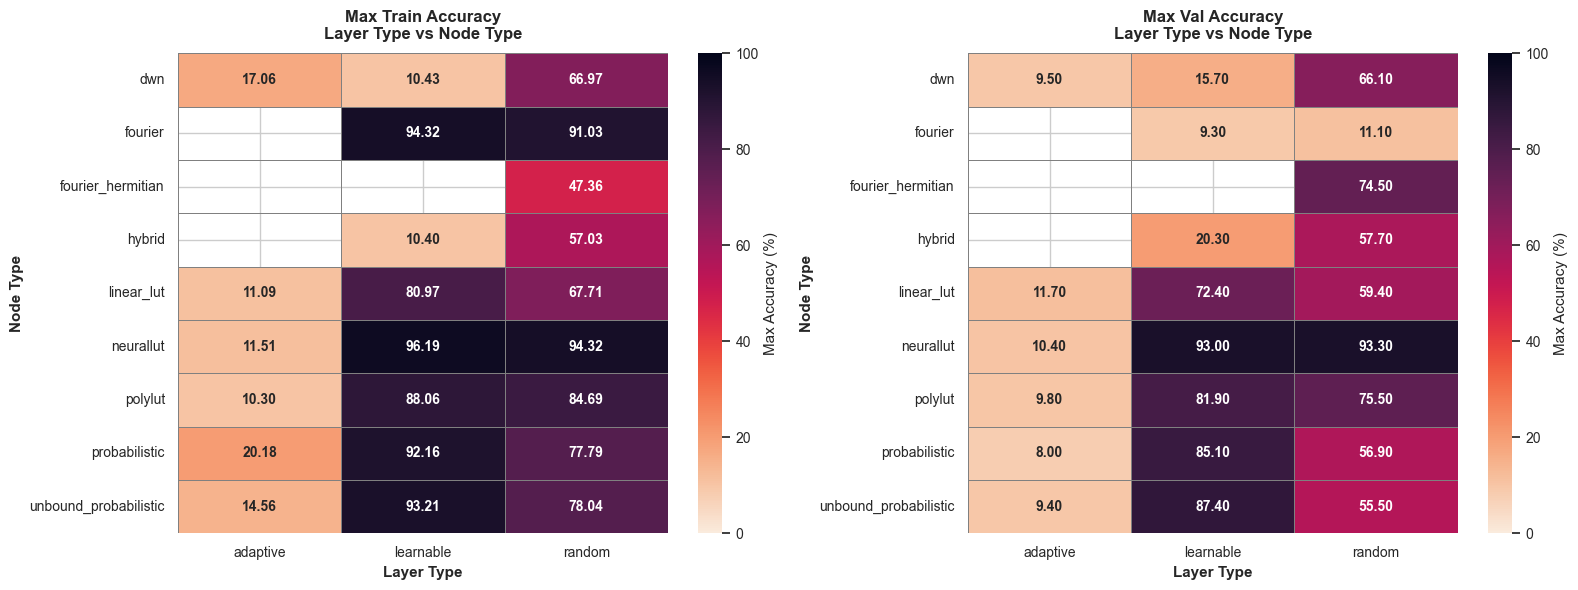

In [6]:
# Layer vs Node
print("Creating Layer vs Node heatmaps...")
fig = create_combination_heatmaps(df_full, 'layer_type', 'node_type', metric_name='accuracy')
fig.savefig(OUTPUT_DIR / 'heatmap_layer_vs_node.png', dpi=150, bbox_inches='tight')
plt.show()

Creating Layer vs Encoder heatmaps...


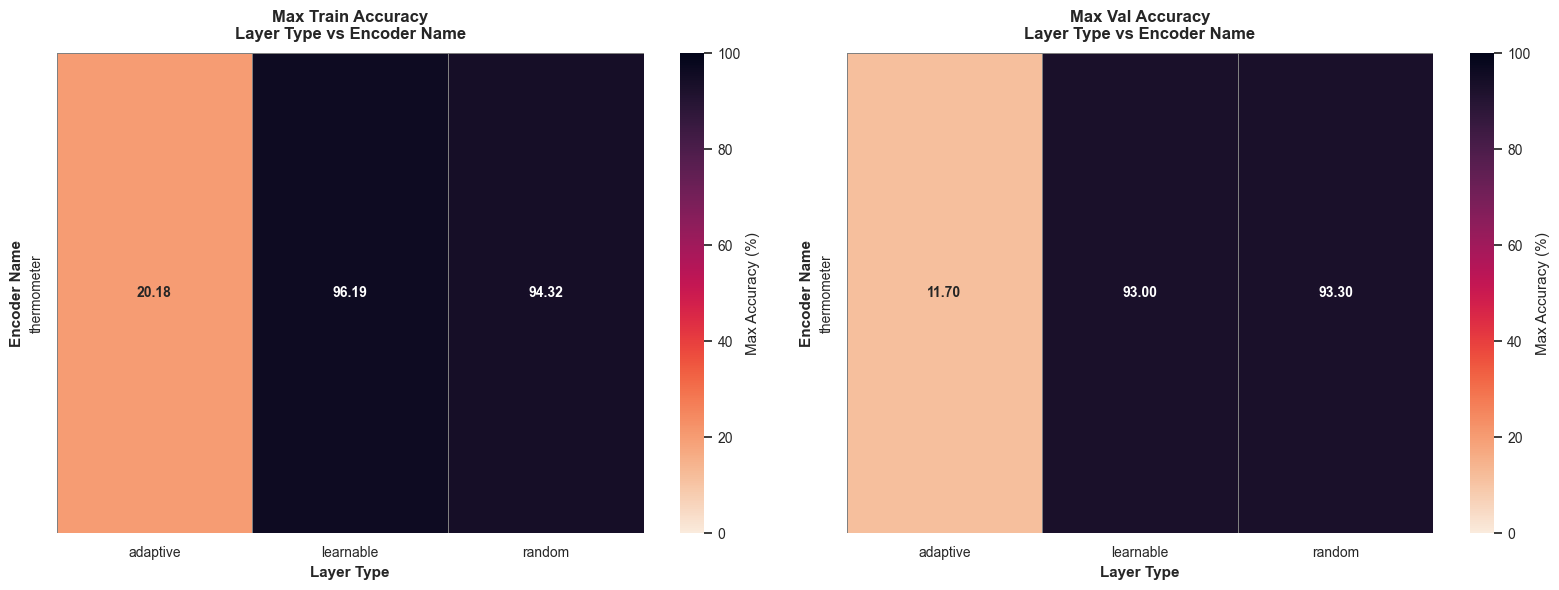

In [7]:
# Layer vs Encoder
print("Creating Layer vs Encoder heatmaps...")
fig = create_combination_heatmaps(df_full, 'layer_type', 'encoder_name', metric_name='accuracy')
fig.savefig(OUTPUT_DIR / 'heatmap_layer_vs_encoder.png', dpi=150, bbox_inches='tight')
plt.show()

Creating Node vs Encoder heatmaps...


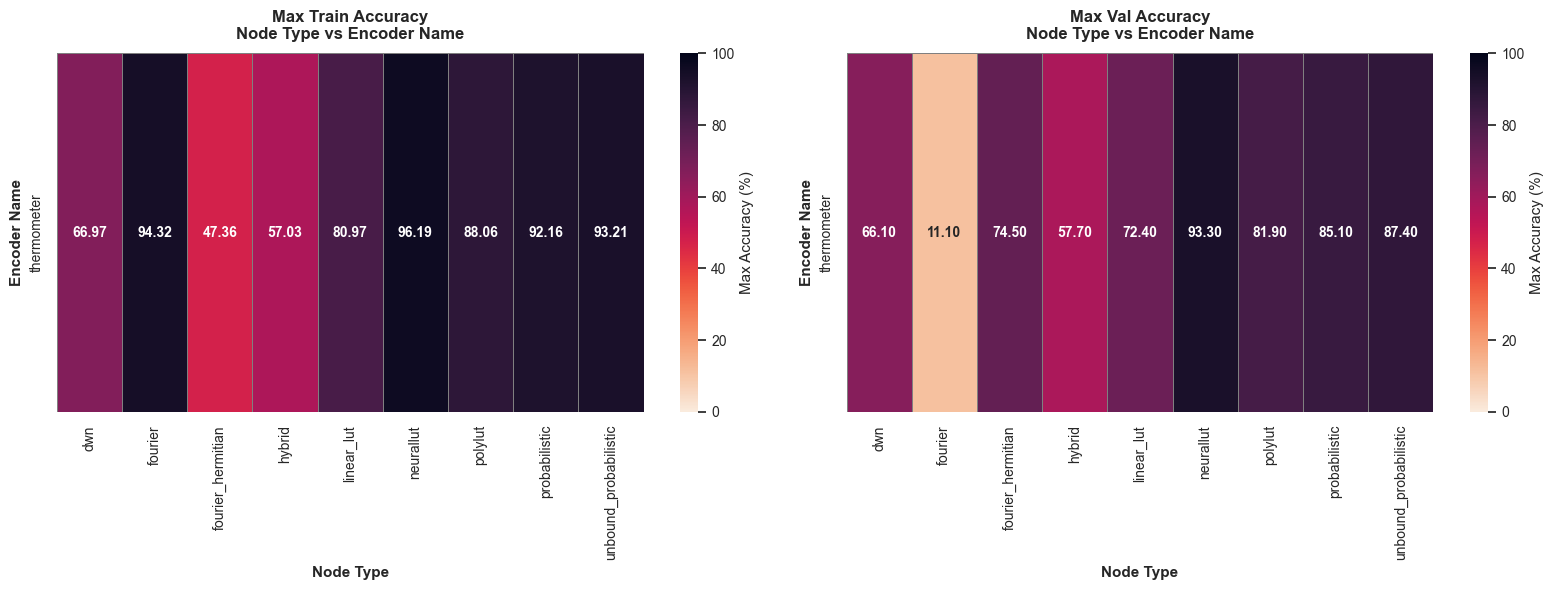

In [8]:
# Node vs Encoder
print("Creating Node vs Encoder heatmaps...")
fig = create_combination_heatmaps(df_full, 'node_type', 'encoder_name', metric_name='accuracy')
fig.savefig(OUTPUT_DIR / 'heatmap_node_vs_encoder.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Training Curves for Top-K Experiments

Show training and validation curves for all logged metrics for the top 15 experiments by validation accuracy.

In [9]:
# Find top-k experiments by max validation accuracy
k = 15

# Get max val accuracy for each experiment
val_acc = df_full[
    (df_full['phase'] == 'val') & 
    (df_full['metric_name'] == 'accuracy')
].groupby('experiment_id')['metric_value'].max().reset_index()

val_acc = val_acc.sort_values('metric_value', ascending=False).head(k)
top_k_ids = val_acc['experiment_id'].tolist()

print(f"Top {k} experiments by validation accuracy:")
for i, (exp_id, acc) in enumerate(zip(val_acc['experiment_id'], val_acc['metric_value']), 1):
    exp_info = df_experiments[df_experiments['id'] == exp_id].iloc[0]
    print(f"{i}. Exp {exp_id}: {acc:.2f}% - {exp_info['layer_type']}/{exp_info['node_type']}/{exp_info['encoder_name']}")

Top 15 experiments by validation accuracy:
1. Exp 7: 93.30% - random/neurallut/thermometer
2. Exp 11: 93.00% - learnable/neurallut/thermometer
3. Exp 15: 87.40% - learnable/unbound_probabilistic/thermometer
4. Exp 14: 85.10% - learnable/probabilistic/thermometer
5. Exp 12: 81.90% - learnable/polylut/thermometer
6. Exp 6: 75.50% - random/polylut/thermometer
7. Exp 9: 74.50% - random/fourier_hermitian/thermometer
8. Exp 10: 72.40% - learnable/linear_lut/thermometer
9. Exp 4: 66.10% - random/dwn/thermometer
10. Exp 8: 59.40% - random/linear_lut/thermometer
11. Exp 3: 57.70% - random/hybrid/thermometer
12. Exp 5: 56.90% - random/probabilistic/thermometer
13. Exp 2: 55.50% - random/unbound_probabilistic/thermometer
14. Exp 16: 20.30% - learnable/hybrid/thermometer
15. Exp 13: 15.70% - learnable/dwn/thermometer


In [10]:
def plot_training_curves(df, exp_ids, metric_names=None, save_path=None):
    """
    Plot training curves for specified experiments and metrics.
    
    Args:
        df: Full dataframe with experiments and metrics
        exp_ids: List of experiment IDs to plot
        metric_names: List of metric names to plot (None = all)
        save_path: Optional path to save figure
    """
    # Get unique metrics if not specified
    if metric_names is None:
        metric_names = df[df['experiment_id'].isin(exp_ids)]['metric_name'].unique()
    
    n_metrics = len(metric_names)
    fig, axes = plt.subplots(n_metrics, 2, figsize=(16, 5*n_metrics))
    if n_metrics == 1:
        axes = axes.reshape(1, -1)
    
    # Use a better color palette
    colors = sns.color_palette("husl", len(exp_ids))
    
    for row, metric_name in enumerate(metric_names):
        for col, phase in enumerate(['train', 'val']):
            ax = axes[row, col]
            
            for i, exp_id in enumerate(exp_ids):
                # Get data for this experiment, metric, and phase
                data = df[
                    (df['experiment_id'] == exp_id) &
                    (df['metric_name'] == metric_name) &
                    (df['phase'] == phase)
                ].sort_values('epoch')
                
                if len(data) > 0:
                    exp_info = df_experiments[df_experiments['id'] == exp_id].iloc[0]
                    label = f"{exp_id}: {exp_info['layer_type'][:3]}/{exp_info['node_type'][:8]}/{exp_info['encoder_name'][:6]}"
                    
                    ax.plot(data['epoch'], data['metric_value'], 
                           color=colors[i], alpha=0.8, linewidth=2, label=label, marker='o', markersize=3)
            
            ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
            ax.set_ylabel(metric_name.capitalize(), fontsize=11, fontweight='bold')
            ax.set_title(f'{phase.capitalize()} {metric_name.capitalize()}', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Add legend to first plot only
            if row == 0 and col == 1:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, frameon=True, shadow=True)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    return fig

Plotting training curves for top 15 experiments...


Saved to ../outputs/training_curves_top15.png


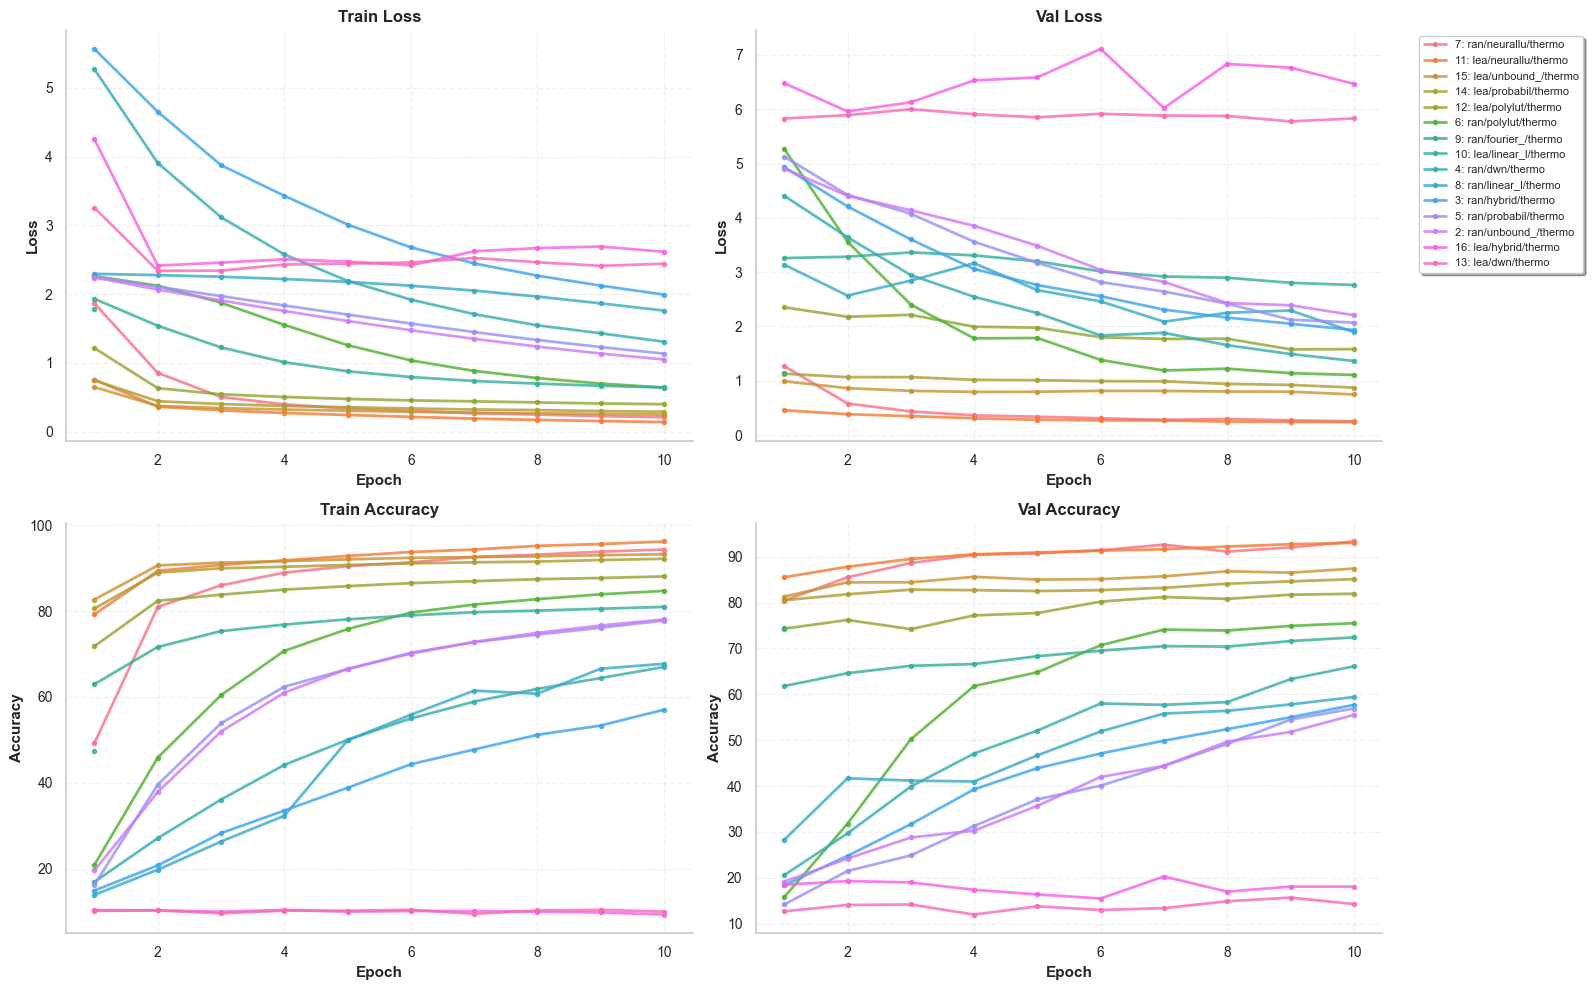

In [11]:
# Plot training curves for top-k experiments
print(f"Plotting training curves for top {k} experiments...")
fig = plot_training_curves(
    df_full, 
    top_k_ids, 
    metric_names=['loss', 'accuracy'],  # Adjust based on your metrics
    save_path=OUTPUT_DIR / f'training_curves_top{k}.png'
)
plt.show()

## 4. Gradient and Weight Evolution Heatmaps

Compare gradient/weight distributions across different node types for experiments with the same layer type and encoder.

In [12]:
def load_histogram_data(histogram_file):
    """Load pre-computed histogram data from pickle file."""
    with open(histogram_file, 'rb') as f:
        return pickle.load(f)

def extract_histogram_matrix(data, data_type='weights', layer_filter=None):
    """
    Extract histogram matrix from loaded data.
    
    Returns:
        hist_matrix: array shape (bins, epochs)
        bin_edges: array shape (bins+1,)
        epochs: list of epoch numbers
    """
    epochs_dict = data.get('epochs', {})
    if not epochs_dict:
        return None, None, None
    
    epochs = sorted(epochs_dict.keys())
    hist_key = 'weight_histograms' if data_type == 'weights' else 'gradient_histograms'
    
    # Get first parameter matching layer_filter
    first_epoch_data = epochs_dict[epochs[0]][hist_key]
    if layer_filter:
        param_names = [k for k in first_epoch_data.keys() if layer_filter in k]
    else:
        param_names = list(first_epoch_data.keys())[:1]  # First layer only
    
    if not param_names:
        return None, None, None
    
    param_name = param_names[0]
    
    # Get global bin range
    all_edges = [epochs_dict[e][hist_key][param_name]['bin_edges'] 
                 for e in epochs if param_name in epochs_dict[e][hist_key]]
    global_min = min(edges[0] for edges in all_edges)
    global_max = max(edges[-1] for edges in all_edges)
    num_bins = data.get('num_bins', 256)
    global_bins = np.linspace(global_min, global_max, num_bins + 1)
    
    # Build matrix
    hist_matrix = np.zeros((num_bins, len(epochs)), dtype=float)
    
    for i, epoch in enumerate(epochs):
        if param_name in epochs_dict[epoch][hist_key]:
            param_data = epochs_dict[epoch][hist_key][param_name]
            local_hist = param_data['hist']
            local_edges = param_data['bin_edges']
            local_centers = 0.5 * (local_edges[:-1] + local_edges[1:])
            
            for count, center in zip(local_hist, local_centers):
                bin_idx = np.digitize(center, global_bins) - 1
                bin_idx = np.clip(bin_idx, 0, num_bins - 1)
                hist_matrix[bin_idx, i] += count
    
    return hist_matrix, global_bins, epochs, param_name

In [13]:
# Find experiments with gradient snapshots
gradient_files = list(GRADIENTS_DIR.glob('exp_*_histograms.pkl'))
print(f"Found {len(gradient_files)} gradient histogram files")

# Map experiment IDs to gradient files
exp_to_gradient = {}
for gf in gradient_files:
    exp_id = int(gf.stem.split('_')[1])
    exp_to_gradient[exp_id] = gf

print(f"Experiments with gradients: {sorted(exp_to_gradient.keys())[:20]}...")

Found 23 gradient histogram files
Experiments with gradients: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21]...


In [14]:
def plot_gradient_comparison_grid(df_experiments, exp_to_gradient, 
                                 fixed_layer='random', fixed_encoder='thermometer',
                                 data_type='weights', layer_idx=0):
    """
    Create a grid of heatmaps comparing gradients/weights across node types.
    Each row = different node type, each column = different layer in the network.
    
    Args:
        df_experiments: DataFrame with experiment info
        exp_to_gradient: Dict mapping exp_id to gradient file path
        fixed_layer: Fixed layer type to compare
        fixed_encoder: Fixed encoder to compare
        data_type: 'weights' or 'gradients'
        layer_idx: Which layer to show (0, 1, etc.)
    """
    # Find experiments matching criteria
    matching = df_experiments[
        (df_experiments['layer_type'] == fixed_layer) &
        (df_experiments['encoder_name'] == fixed_encoder) &
        (df_experiments['status'] == 'completed')
    ]
    
    # Group by node type
    node_types = matching['node_type'].unique()
    print(f"Found {len(node_types)} node types: {node_types}")
    
    # Filter to only those with gradient files
    exp_data = []
    for node_type in node_types:
        exps = matching[matching['node_type'] == node_type]
        for _, exp in exps.iterrows():
            if exp['id'] in exp_to_gradient:
                exp_data.append({
                    'node_type': node_type,
                    'exp_id': exp['id'],
                    'gradient_file': exp_to_gradient[exp['id']]
                })
                break  # Take first matching experiment
    
    if not exp_data:
        print("No experiments found with gradient files!")
        return None
    
    print(f"\nPlotting {len(exp_data)} experiments:")
    for ed in exp_data:
        print(f"  - Exp {ed['exp_id']}: {ed['node_type']}")
    
    # Load and plot
    n_rows = len(exp_data)
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    # Use better colormap
    cmap = sns.color_palette("mako", as_cmap=True)
    
    for ax, ed in zip(axes, exp_data):
        # Load histogram data
        try:
            data = load_histogram_data(ed['gradient_file'])
            
            # Get layer name pattern (layers.0, layers.1, etc.)
            layer_filter = f'layers.{layer_idx}' if layer_idx >= 0 else None
            
            hist_matrix, bin_edges, epochs, param_name = extract_histogram_matrix(
                data, data_type=data_type, layer_filter=layer_filter
            )
            
            if hist_matrix is None:
                ax.text(0.5, 0.5, f'No data for {ed["node_type"]}', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                continue
            
            # Normalize to density per epoch
            col_sums = hist_matrix.sum(axis=0, keepdims=True)
            col_sums[col_sums == 0] = 1
            hist_matrix = hist_matrix / col_sums
            
            # Plot heatmap with better colormap
            im = ax.imshow(hist_matrix, origin='lower', aspect='auto', cmap=cmap,
                          extent=(min(epochs)-0.5, max(epochs)+0.5, bin_edges[0], bin_edges[-1]))
            
            ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
            ax.set_ylabel(f'{data_type.capitalize()} Value', fontsize=11, fontweight='bold')
            layer_name = param_name.split('.')[-2] if '.' in param_name else 'unknown'
            ax.set_title(f'Node: {ed["node_type"]} | Layer: {layer_name} | {data_type.capitalize()} Distribution', 
                        fontsize=12, fontweight='bold')
            
            cbar = plt.colorbar(im, ax=ax, label='Density')
            cbar.ax.set_ylabel('Density', fontsize=10, fontweight='bold')
            
        except Exception as e:
            print(f"Error loading {ed['gradient_file']}: {e}")
            ax.text(0.5, 0.5, f'Error: {ed["node_type"]}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
    
    plt.tight_layout()
    return fig

Creating weight evolution heatmaps...
Found 8 node types: ['fourier' 'unbound_probabilistic' 'hybrid' 'dwn' 'probabilistic'
 'polylut' 'neurallut' 'linear_lut']

Plotting 8 experiments:
  - Exp 1: fourier
  - Exp 2: unbound_probabilistic
  - Exp 3: hybrid
  - Exp 4: dwn
  - Exp 5: probabilistic
  - Exp 6: polylut
  - Exp 7: neurallut
  - Exp 8: linear_lut


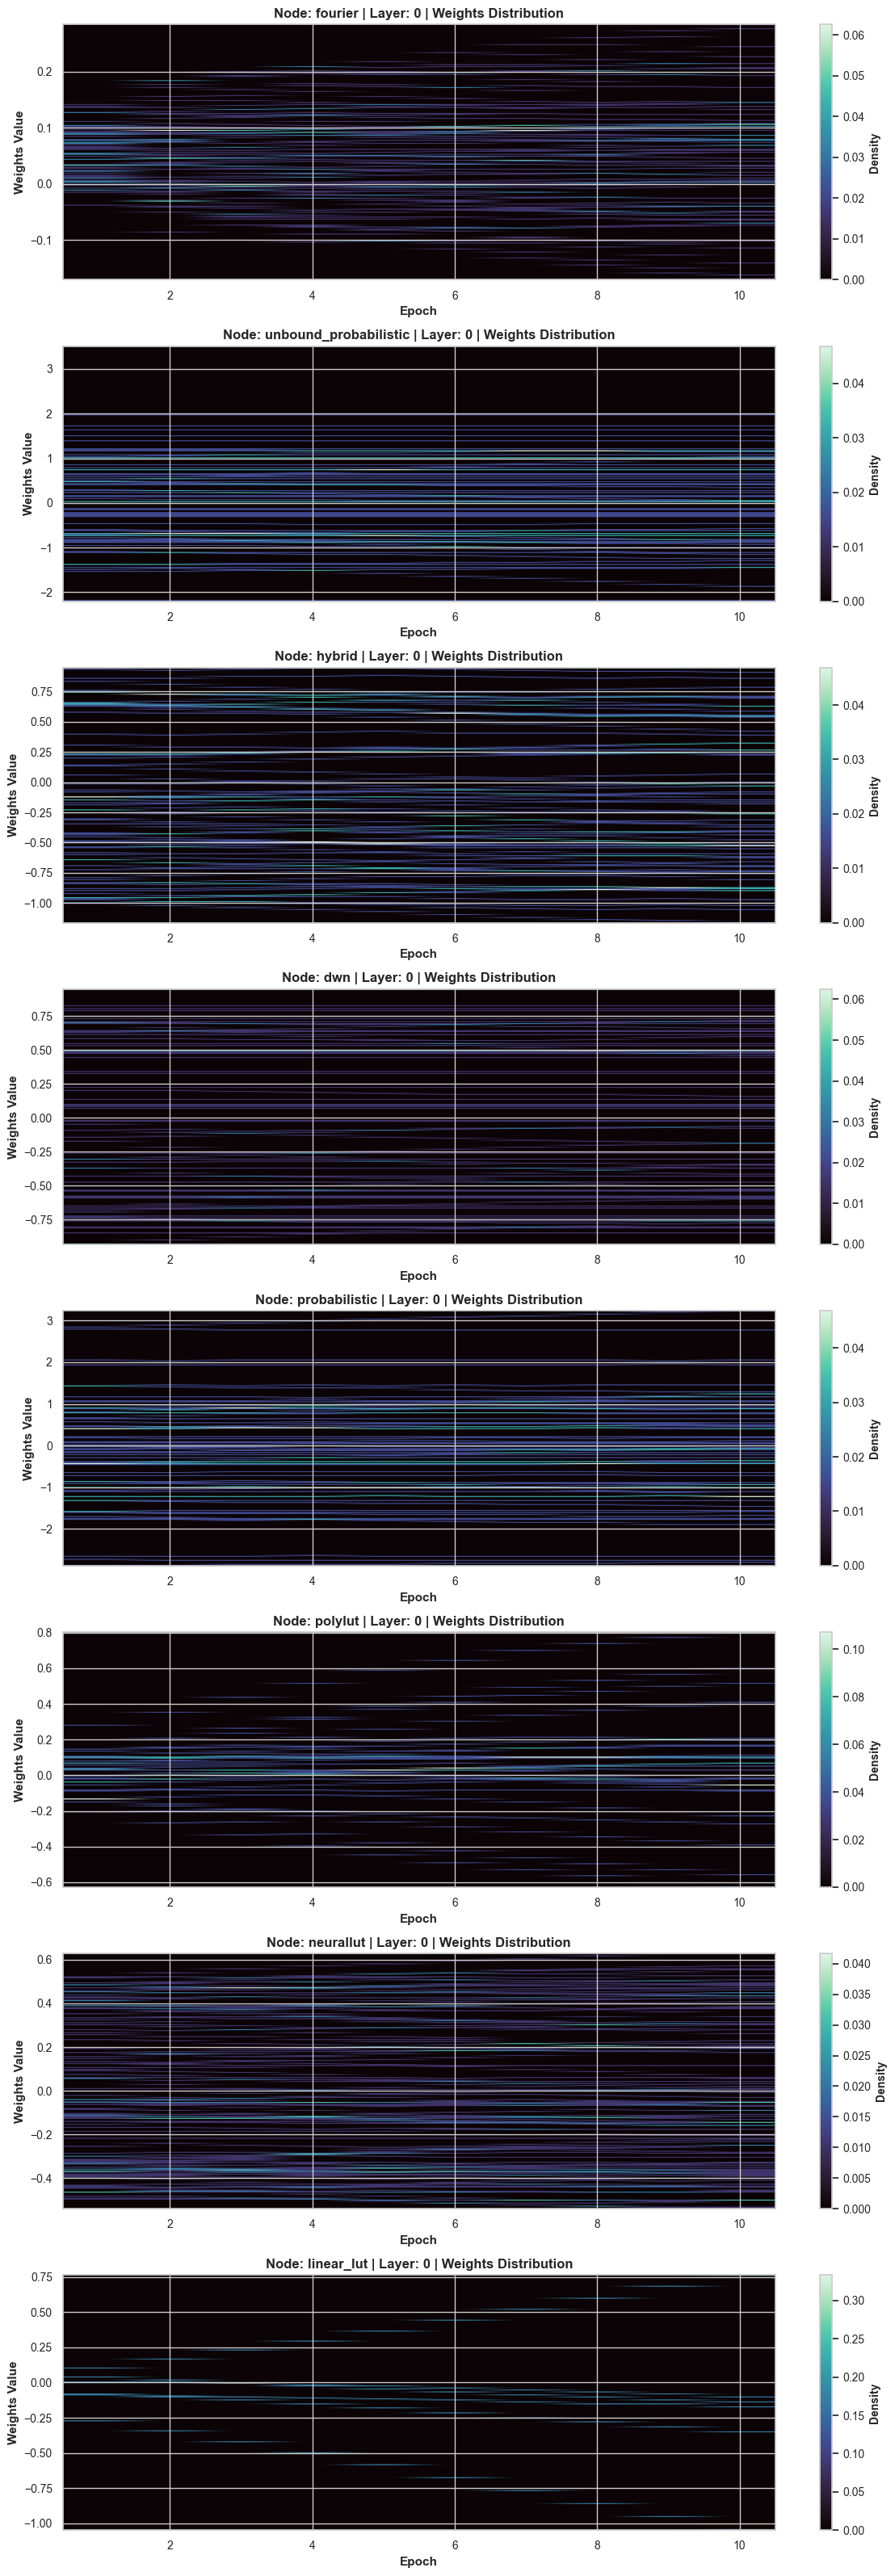

In [15]:
# Plot weight evolution comparison
print("Creating weight evolution heatmaps...")
fig = plot_gradient_comparison_grid(
    df_experiments, 
    exp_to_gradient,
    fixed_layer='random',
    fixed_encoder='thermometer',
    data_type='weights',
    layer_idx=0  # First layer
)
if fig:
    fig.savefig(OUTPUT_DIR / 'weight_evolution_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

Creating gradient evolution heatmaps...
Found 8 node types: ['fourier' 'unbound_probabilistic' 'hybrid' 'dwn' 'probabilistic'
 'polylut' 'neurallut' 'linear_lut']

Plotting 8 experiments:
  - Exp 1: fourier
  - Exp 2: unbound_probabilistic
  - Exp 3: hybrid
  - Exp 4: dwn
  - Exp 5: probabilistic
  - Exp 6: polylut
  - Exp 7: neurallut
  - Exp 8: linear_lut


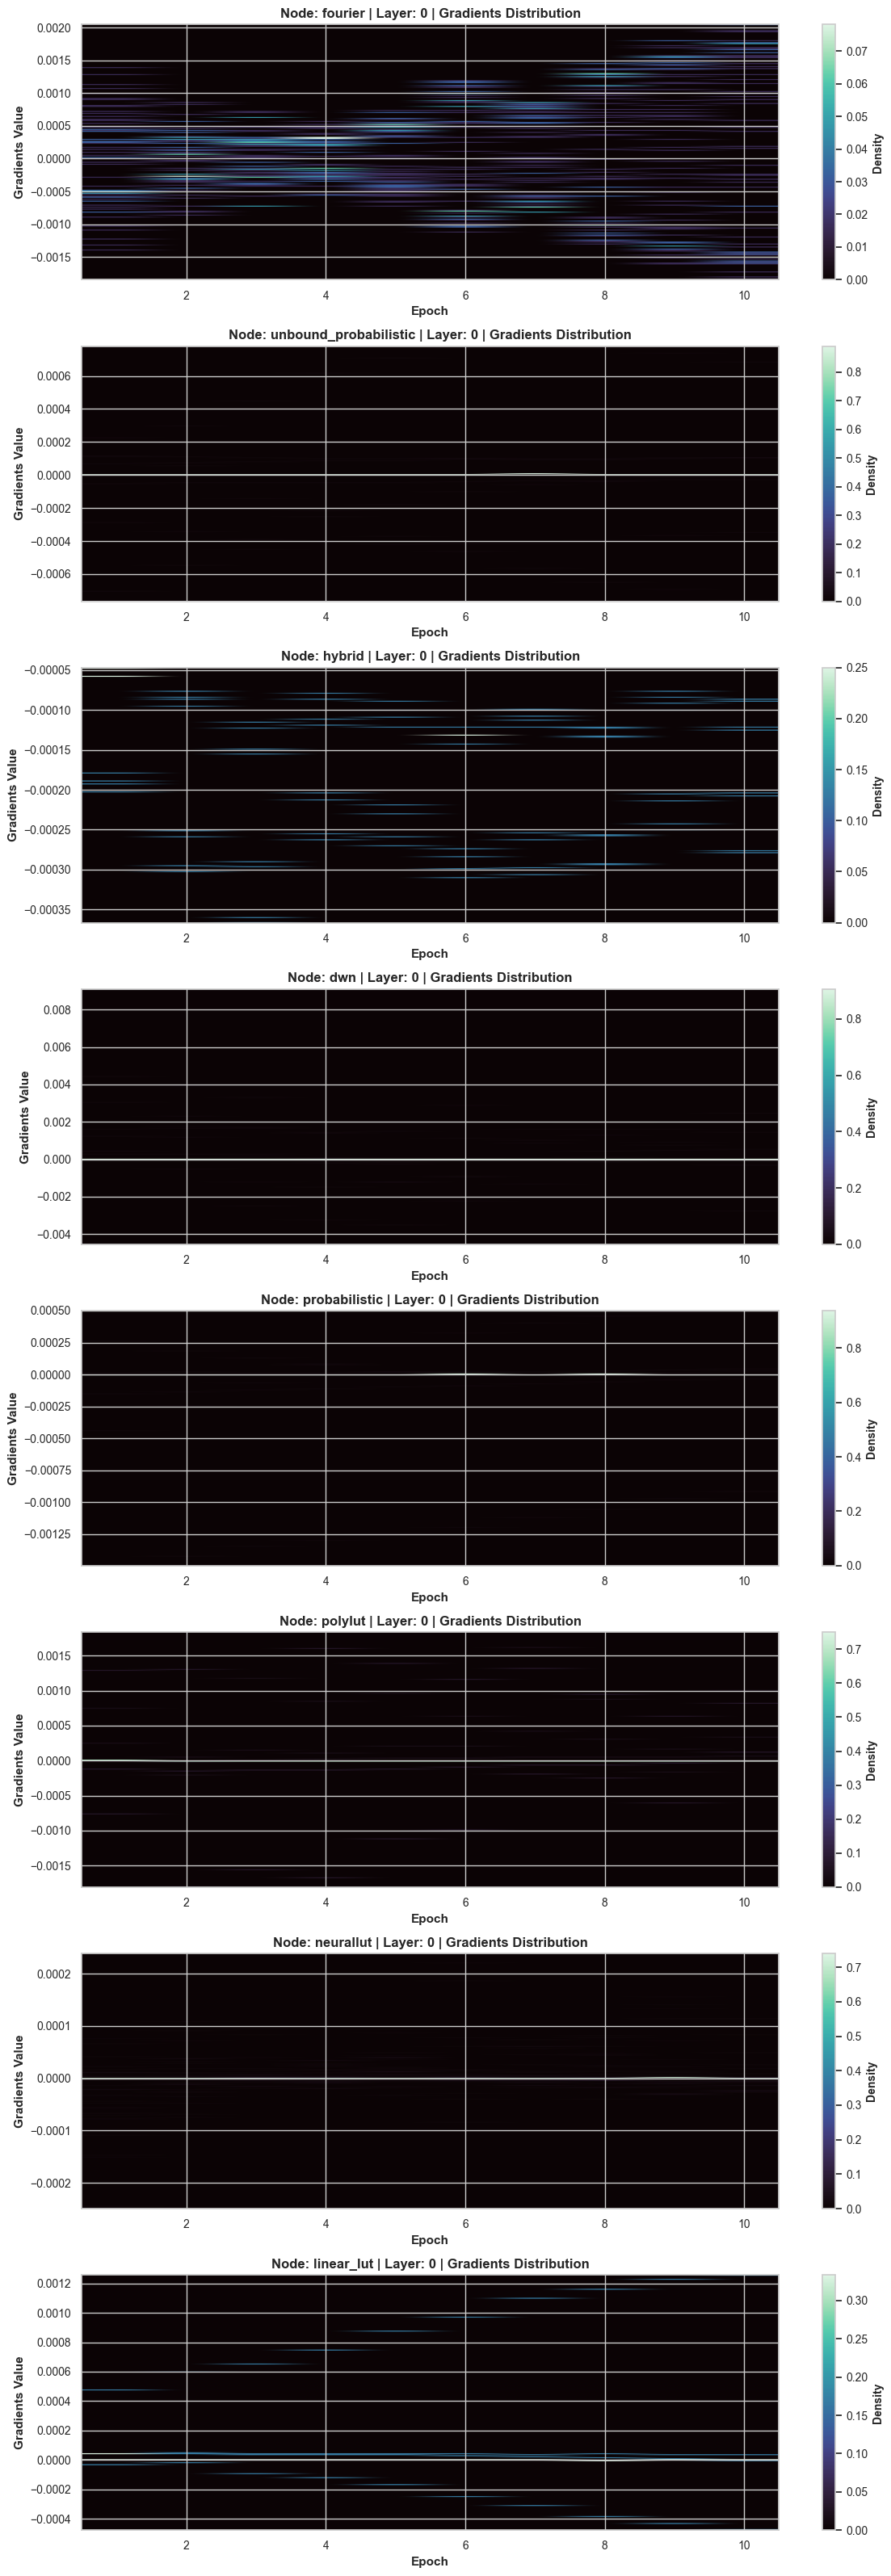

In [16]:
# Plot gradient evolution comparison
print("Creating gradient evolution heatmaps...")
fig = plot_gradient_comparison_grid(
    df_experiments, 
    exp_to_gradient,
    fixed_layer='random',
    fixed_encoder='thermometer',
    data_type='gradients',
    layer_idx=0  # First layer
)
if fig:
    fig.savefig(OUTPUT_DIR / 'gradient_evolution_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

## 5. Summary Statistics

In [17]:
# Summary statistics
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)

# Best configurations
val_acc_summary = df_full[
    (df_full['phase'] == 'val') & 
    (df_full['metric_name'] == 'accuracy')
].groupby(['layer_type', 'node_type', 'encoder_name'])['metric_value'].agg(['max', 'mean', 'count'])

print("\nTop 10 configurations by max validation accuracy:")
print(val_acc_summary.sort_values('max', ascending=False).head(10))

# By component
print("\nBest by layer type:")
print(df_full[
    (df_full['phase'] == 'val') & 
    (df_full['metric_name'] == 'accuracy')
].groupby('layer_type')['metric_value'].agg(['max', 'mean']))

print("\nBest by node type:")
print(df_full[
    (df_full['phase'] == 'val') & 
    (df_full['metric_name'] == 'accuracy')
].groupby('node_type')['metric_value'].agg(['max', 'mean']))

print("\nBest by encoder:")
print(df_full[
    (df_full['phase'] == 'val') & 
    (df_full['metric_name'] == 'accuracy')
].groupby('encoder_name')['metric_value'].agg(['max', 'mean']))

SUMMARY STATISTICS

Top 10 configurations by max validation accuracy:
                                                max   mean  count
layer_type node_type             encoder_name                    
random     neurallut             thermometer   93.3  89.60     10
learnable  neurallut             thermometer   93.0  90.50     10
           unbound_probabilistic thermometer   87.4  85.22     10
           probabilistic         thermometer   85.1  83.00     10
           polylut               thermometer   81.9  78.54     10
random     polylut               thermometer   75.5  59.35     10
           fourier_hermitian     thermometer   74.5  74.50      1
learnable  linear_lut            thermometer   72.4  68.19     10
random     dwn                   thermometer   66.1  49.28     10
           linear_lut            thermometer   59.4  48.02     10

Best by layer type:
             max       mean
layer_type                 
adaptive    11.7   9.711111
learnable   93.0  55.805000
rando

In [18]:
# Close database connection
session.close()
db_manager.close()
print("\nDatabase connection closed.")


Database connection closed.


## Done!

All visualizations have been saved to the `outputs/` directory:
- `heatmap_layer_vs_node.png` - Accuracy heatmap for layer vs node combinations
- `heatmap_layer_vs_encoder.png` - Accuracy heatmap for layer vs encoder combinations
- `heatmap_node_vs_encoder.png` - Accuracy heatmap for node vs encoder combinations
- `training_curves_top15.png` - Training curves for top 15 experiments
- `weight_evolution_comparison.png` - Weight distribution evolution across node types
- `gradient_evolution_comparison.png` - Gradient distribution evolution across node types

NameError: name 'df_duration' is not defined

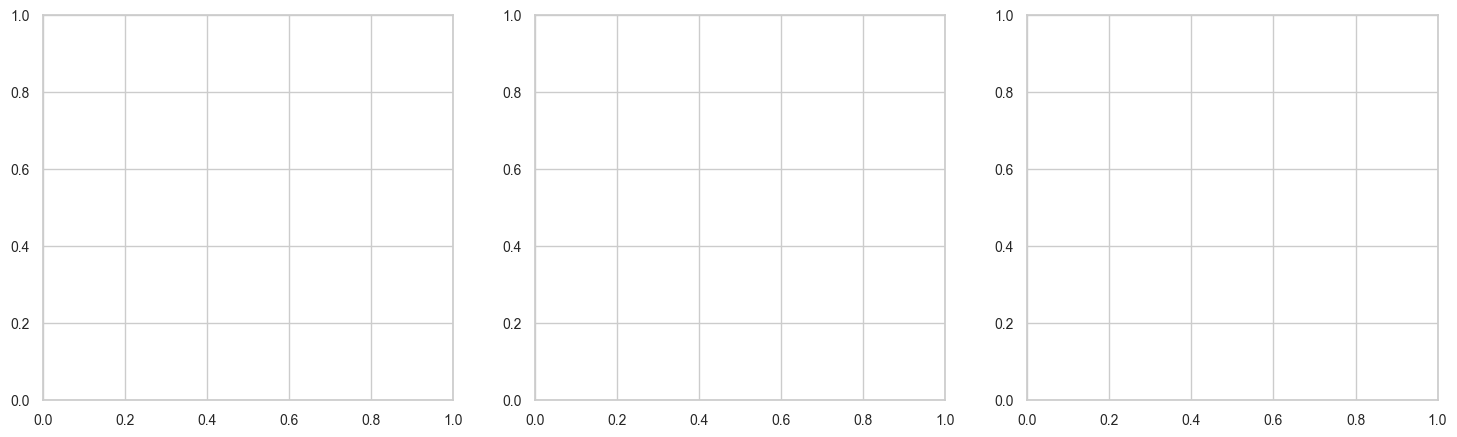

In [19]:
# Scatter plot: Accuracy vs Training Duration per Epoch
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Color by layer type
layer_types = df_duration['layer_type'].unique()
layer_colors = plt.cm.Set3(np.linspace(0, 1, len(layer_types)))
layer_color_map = dict(zip(layer_types, layer_colors))

for layer_type in layer_types:
    data = df_duration[df_duration['layer_type'] == layer_type]
    axes[0].scatter(data['avg_epoch_time'], data['max_val_accuracy'], 
                   label=layer_type, alpha=0.6, s=100, 
                   color=layer_color_map[layer_type], edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Avg Training Duration per Epoch (s)')
axes[0].set_ylabel('Max Validation Accuracy (%)')
axes[0].set_title('Accuracy vs Training Duration\n(Colored by Layer Type)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)

# Color by node type
node_types = df_duration['node_type'].unique()
node_colors = plt.cm.tab10(np.linspace(0, 1, len(node_types)))
node_color_map = dict(zip(node_types, node_colors))

for node_type in node_types:
    data = df_duration[df_duration['node_type'] == node_type]
    axes[1].scatter(data['avg_epoch_time'], data['max_val_accuracy'], 
                   label=node_type, alpha=0.6, s=100,
                   color=node_color_map[node_type], edgecolors='black', linewidth=0.5)

axes[1].set_xlabel('Avg Training Duration per Epoch (s)')
axes[1].set_ylabel('Max Validation Accuracy (%)')
axes[1].set_title('Accuracy vs Training Duration\n(Colored by Node Type)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

# Color by encoder
encoder_names = df_duration['encoder_name'].unique()
encoder_colors = plt.cm.Paired(np.linspace(0, 1, len(encoder_names)))
encoder_color_map = dict(zip(encoder_names, encoder_colors))

for encoder_name in encoder_names:
    data = df_duration[df_duration['encoder_name'] == encoder_name]
    axes[2].scatter(data['avg_epoch_time'], data['max_val_accuracy'], 
                   label=encoder_name, alpha=0.6, s=100,
                   color=encoder_color_map[encoder_name], edgecolors='black', linewidth=0.5)

axes[2].set_xlabel('Avg Training Duration per Epoch (s)')
axes[2].set_ylabel('Max Validation Accuracy (%)')
axes[2].set_title('Accuracy vs Training Duration\n(Colored by Encoder Type)')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(OUTPUT_DIR / 'accuracy_vs_duration_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

# Print efficiency insights
print("\nEfficiency Insights:")
print("="*60)

# Find experiments with good accuracy and low training time
efficient_threshold = df_duration['avg_epoch_time'].quantile(0.5)  # Below median time
accuracy_threshold = df_duration['max_val_accuracy'].quantile(0.75)  # Above 75th percentile accuracy

efficient_exps = df_duration[
    (df_duration['avg_epoch_time'] <= efficient_threshold) & 
    (df_duration['max_val_accuracy'] >= accuracy_threshold)
].sort_values('max_val_accuracy', ascending=False)

print(f"\nMost Efficient Experiments (fast training + high accuracy):")
print(f"Training time <= {efficient_threshold:.2f}s, Accuracy >= {accuracy_threshold:.2f}%")
print(efficient_exps[['experiment_id', 'layer_type', 'node_type', 'encoder_name', 
                       'avg_epoch_time', 'max_val_accuracy']].head(10))

# Calculate efficiency score (accuracy per second)
df_duration['efficiency_score'] = df_duration['max_val_accuracy'] / df_duration['avg_epoch_time']
best_efficiency = df_duration.nlargest(5, 'efficiency_score')

print(f"\nBest Efficiency Score (Accuracy / Training Time):")
print(best_efficiency[['experiment_id', 'layer_type', 'node_type', 'encoder_name', 
                        'avg_epoch_time', 'max_val_accuracy', 'efficiency_score']])

In [ ]:
# Bar plot: Average training duration per epoch by configuration
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Group by layer type
layer_duration = df_duration.groupby('layer_type')['avg_epoch_time'].mean().sort_values(ascending=False)
axes[0].bar(range(len(layer_duration)), layer_duration.values, color='steelblue', alpha=0.7)
axes[0].set_xticks(range(len(layer_duration)))
axes[0].set_xticklabels(layer_duration.index, rotation=45, ha='right')
axes[0].set_ylabel('Avg Epoch Time (s)')
axes[0].set_title('Average Training Duration per Epoch by Layer Type')
axes[0].grid(True, alpha=0.3, axis='y')

# Group by node type
node_duration = df_duration.groupby('node_type')['avg_epoch_time'].mean().sort_values(ascending=False)
axes[1].bar(range(len(node_duration)), node_duration.values, color='coral', alpha=0.7)
axes[1].set_xticks(range(len(node_duration)))
axes[1].set_xticklabels(node_duration.index, rotation=45, ha='right')
axes[1].set_ylabel('Avg Epoch Time (s)')
axes[1].set_title('Average Training Duration per Epoch by Node Type')
axes[1].grid(True, alpha=0.3, axis='y')

# Group by encoder
encoder_duration = df_duration.groupby('encoder_name')['avg_epoch_time'].mean().sort_values(ascending=False)
axes[2].bar(range(len(encoder_duration)), encoder_duration.values, color='mediumseagreen', alpha=0.7)
axes[2].set_xticks(range(len(encoder_duration)))
axes[2].set_xticklabels(encoder_duration.index, rotation=45, ha='right')
axes[2].set_ylabel('Avg Epoch Time (s)')
axes[2].set_title('Average Training Duration per Epoch by Encoder Type')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig.savefig(OUTPUT_DIR / 'training_duration_barplot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining Duration Summary:")
print(f"Fastest layer type: {layer_duration.idxmin()} ({layer_duration.min():.2f}s)")
print(f"Slowest layer type: {layer_duration.idxmax()} ({layer_duration.max():.2f}s)")
print(f"Fastest node type: {node_duration.idxmin()} ({node_duration.min():.2f}s)")
print(f"Slowest node type: {node_duration.idxmax()} ({node_duration.max():.2f}s)")
print(f"Fastest encoder: {encoder_duration.idxmin()} ({encoder_duration.min():.2f}s)")
print(f"Slowest encoder: {encoder_duration.idxmax()} ({encoder_duration.max():.2f}s)")

In [ ]:
# Calculate average training duration per epoch for each experiment
duration_data = []

for exp_id in df_experiments['id']:
    # Get training phase measurements
    train_mps = df_full[
        (df_full['experiment_id'] == exp_id) & 
        (df_full['phase'] == 'train')
    ][['epoch', 'epoch_time']].drop_duplicates()
    
    if len(train_mps) > 0:
        avg_epoch_time = train_mps['epoch_time'].mean()
        
        # Get max validation accuracy for this experiment
        val_acc = df_full[
            (df_full['experiment_id'] == exp_id) & 
            (df_full['phase'] == 'val') & 
            (df_full['metric_name'] == 'accuracy')
        ]['metric_value'].max()
        
        exp_info = df_experiments[df_experiments['id'] == exp_id].iloc[0]
        
        duration_data.append({
            'experiment_id': exp_id,
            'layer_type': exp_info['layer_type'],
            'node_type': exp_info['node_type'],
            'encoder_name': exp_info['encoder_name'],
            'avg_epoch_time': avg_epoch_time,
            'max_val_accuracy': val_acc if not pd.isna(val_acc) else 0
        })

df_duration = pd.DataFrame(duration_data)
print(f"Duration data shape: {df_duration.shape}")
print(df_duration.head(10))
print(f"\nEpoch time range: {df_duration['avg_epoch_time'].min():.2f}s - {df_duration['avg_epoch_time'].max():.2f}s")

## 6. Training Duration Analysis

Analyze training efficiency by examining the relationship between training duration per epoch and model performance.